In [1]:
cd /home/dmoi/projects/foldtree2/

/home/dmoi/projects/foldtree2


# FoldTree2: Custom Substitution Matrix and Phylogenetic Analysis Workflow

This notebook demonstrates a workflow for generating custom substitution matrices from structure-based sequence alignments and using them for phylogenetic inference with RAxML-NG. The process leverages deep learning-based encodings of protein structures and integrates them into standard phylogenetic tools.

## Workflow Overview

1. **Setup and Data Preparation**
	- Set working directories and import required modules.
	- Load cluster representative information and download structure files for each cluster.

2. **Structure Alignment and Encoding**
	- Perform all-vs-all structure alignments within each cluster using Foldseek.
	- Encode structures using a trained encoder model to obtain discrete sequence representations.

3. **Sequence Processing**
	- Replace special characters to ensure compatibility with downstream tools.
	- Convert encoded sequences to ordinal and hexadecimal representations.

4. **Substitution Matrix Construction**
	- Calculate pairwise character substitution counts from alignments.
	- Compute background frequencies and log-odds substitution matrices.
	- Output matrices in formats compatible with MAFFT and RAxML-NG.

5. **Phylogenetic Inference**
	- Align encoded sequences using MAFFT with the custom matrix.
	- Run RAxML-NG with the custom substitution matrix for tree inference and ancestral state reconstruction.

6. **Utilities**
	- Functions for converting between formats, running external tools, and post-processing results.

## Key Features

- **Custom Alphabet:** Encoded sequences use a learned alphabet, enabling structure-informed evolutionary analysis.
- **Flexible Matrix Generation:** Outputs both MAFFT and RAxML-NG compatible matrices.
- **Automated Pipeline:** From raw structures to phylogenetic trees and ancestral reconstructions.

## Usage Notes

- Ensure all dependencies (e.g., MAFFT, Foldseek, RAxML-NG, PyTorch, BioPython) are installed and accessible.
- Adjust paths and parameters (e.g., model names, dataset locations) as needed for your environment.
- The notebook is modular; you can run individual sections as required for your analysis.

---

This workflow enables advanced phylogenetic analysis using structure-derived sequence encodings, facilitating the study of protein evolution beyond traditional sequence-based approaches.

In [51]:
import sys
sys.path.append('/home/dmoi/projects/foldtree2')
#read the afdb clusters file
import pandas as pd
import numpy as np
import glob
import os
#autoreload
import pickle
from src import AFDB_tools
import toytree
import tqdm
from matplotlib import pyplot as plt
import torch
import copy
from foldtree2.src.pdbgraph import *
import foldtree2.src.foldtree2_ecddcd as ft2
import importlib
from foldtree2.src import foldseek2tree
importlib.reload(ft2)


<module 'foldtree2_ecddcd' from '/home/dmoi/projects/foldtree2/src/foldtree2_ecddcd.py'>

In [52]:
#change the modelname to the one you want to load
modelname = 'testfft400'
modeldir = 'models/'
with open( modeldir + modelname + '.pkl', 'rb') as f:
	encoder, decoder = pickle.load(f)


In [53]:
print( encoder)
print( decoder)

mk1_Encoder(
  (convs): ModuleList(
    (0): ModuleDict(
      (res_contactPoints_res): TransformerConv(400, 400, heads=5)
      (res_hbond_res): TransformerConv(400, 400, heads=5)
    )
  )
  (norms): ModuleList(
    (0): GraphNorm(400)
  )
  (bn): BatchNorm1d(857, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout): Dropout(p=0.005, inplace=False)
  (jk): JumpingKnowledge(cat)
  (ffin): Sequential(
    (0): Linear(in_features=1017, out_features=800, bias=True)
    (1): GELU(approximate='none')
    (2): Linear(in_features=800, out_features=400, bias=True)
    (3): GELU(approximate='none')
    (4): DynamicTanh(normalized_shape=400, alpha_init_value=0.5, channels_last=True)
  )
  (lin): Sequential(
    (0): DynamicTanh(normalized_shape=400, alpha_init_value=0.5, channels_last=True)
    (1): Linear(in_features=400, out_features=400, bias=True)
    (2): GELU(approximate='none')
    (3): Linear(in_features=400, out_features=400, bias=True)
    (4): GELU(approximate=

In [54]:
print( encoder.num_embeddings)

40


In [55]:
datadir = '../../datasets/'
model_dir = 'models/'

outdir_base = '../../results/foldtree2/'

if not os.path.exists(outdir_base):
	os.makedirs(outdir_base)

#output for matrices 
matdir = outdir_base + 'matrices/'
if not os.path.exists(matdir):
	os.makedirs(matdir)

#output for trees
treedir = outdir_base + 'trees/'
if not os.path.exists(treedir):
	os.makedirs(treedir)

In [56]:
#read the afdb rep file
reps = pd.read_table( datadir + 'afdbclusters/1-AFDBClusters-entryId_repId_taxId.tsv', header=None, names=['entryId', 'repId', 'taxId'] )
print( 'reps' , reps.head() )

reps       entryId       repId    taxId
0  A0A009E921  A0A009E921  1310605
1  A0A009F5K6  A0A009E921  1310605
2  A0A009E9H3  A0A009E9H3  1310605
3  A0A484ZLT0  A0A009E9H3    82979
4  A0A009ECR5  A0A009ECR5  1310605


In [57]:
repdirs = '../../datasets/foldtree2/struct_align/'

In [58]:
mkdirs = False
if mkdirs == True:
	#make a structure alignment directory
	if not os.path.exists( 'struct_align' ):
		os.makedirs( 'struct_align' )
	
	#make a directory for each cluster representative
	for rep in reps['repId']:
		if not os.path.exists( datadir +'struct_align/' + rep  ):
			os.makedirs(datadir + 'struct_align/' + rep  )
		if not os.path.exists( datadir+ 'struct_align/' + rep  + '/structs/'):
			os.makedirs( datadir+ 'struct_align/' + rep + '/structs/' )
			

In [59]:
#download n struct members for each cluster
dl_structs = False
if dl_structs == True:
	n = 5
	for rep in tqdm.tqdm(reps.repId.unique() ):
		subdf = reps[ reps['repId'] == rep ]
		if len(subdf) < n:
			n = len(subdf)
		subdf = subdf.sample( n = n  )
		subdf = subdf.head( n )
		#download the structures
		for uniID in subdf['entryId']:
			AFDB_tools.grab_struct(uniID , structfolder=datadir+'struct_align/' + rep  + '/structs/')

In [60]:
#for each folder in struct_align, align the structures with all vs all using foldseek
aln_structs = False
if aln_structs == True:
	for rep in tqdm.tqdm(reps.repId.unique() ):
		#align the structures
		foldseek2tree.runFoldseek_allvall_EZsearch( infolder= datadir + 'struct_align/' + rep  + '/structs/', outpath=datadir+'struct_align/' + rep + '/allvall.csv' )


In [61]:

converter = PDB2PyG( aapropcsv='./config/aaindex1.csv')

In [62]:
ndim = 844
alphabetsize = encoder.vector_quantizer.embedding_dim
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

#device = torch.device('cpu')
print(device)

encoder = encoder.to(device)
decoder = decoder.to(device)
encoder.eval()

cuda:0


mk1_Encoder(
  (convs): ModuleList(
    (0): ModuleDict(
      (res_contactPoints_res): TransformerConv(400, 400, heads=5)
      (res_hbond_res): TransformerConv(400, 400, heads=5)
    )
  )
  (norms): ModuleList(
    (0): GraphNorm(400)
  )
  (bn): BatchNorm1d(857, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout): Dropout(p=0.005, inplace=False)
  (jk): JumpingKnowledge(cat)
  (ffin): Sequential(
    (0): Linear(in_features=1017, out_features=800, bias=True)
    (1): GELU(approximate='none')
    (2): Linear(in_features=800, out_features=400, bias=True)
    (3): GELU(approximate='none')
    (4): DynamicTanh(normalized_shape=400, alpha_init_value=0.5, channels_last=True)
  )
  (lin): Sequential(
    (0): DynamicTanh(normalized_shape=400, alpha_init_value=0.5, channels_last=True)
    (1): Linear(in_features=400, out_features=400, bias=True)
    (2): GELU(approximate='none')
    (3): Linear(in_features=400, out_features=400, bias=True)
    (4): GELU(approximate=

In [63]:
from torch_geometric.data import DataLoader
struct_dat = StructureDataset('structalignFFT.h5')
#struct_dat = ft2.StructureDataset('structs_training.h5')
encoder_loader = DataLoader(struct_dat, batch_size=1, shuffle=False)
#encode the structures
encode_alns = False
if encode_alns == True:
	def databatch2list(loader):
		for data in loader:
			data = data.to_data_list()
			for d in data:
				d = d.to(device)
				yield d
	encoder_loader = databatch2list(encoder_loader)
	encoder.encode_structures_fasta(encoder_loader , modelname+'_aln_encoded.fasta' )

/home/dmoi/miniforge3/envs/pyg/lib/python3.12/site-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)
45853it [35:03, 21.80it/s]


In [35]:
encoded_fasta = modelname+'_aln_encoded.fasta' 
encoded_df = ft2.load_encoded_fasta(encoded_fasta, alphabet=encoder.alphabet, replace=False)
print(encoded_df.head())

0it [00:00, ?it/s]

800845it [00:00, 1558281.23it/s]


                                                          seq
protid                                                       
A0A009E921             '$$"##&\t\t%"##
A0A009E9H3  "''$\t"!"&"'"$"''$...
A0A009ETZ7  (&"\t#""""%&""...
A0A009EX88  (\t\t\t"#'&'%...
A0A009EYT2  !&'##...
...                                                       ...
X8H825      '##%(%...
X8IXX3       \t ' &'#&##...
X8J6C8      '&#\t####&&'...
X8JMW4      %%%(##%%'"''...
X8JSL8      %%""'%#'...

[45852 rows x 1 columns]


In [36]:
charset = 249
#make fasta is shifted by 1 and goes from 1-248 included
#0x01 – 0xFF excluding > (0x3E), = (0x3D), < (0x3C), - (0x2D), Space (0x20), Carriage Return (0x0d) and Line Feed (0x0a)
#replace 0x22 or " which is necesary for nexus files and 0x23 or # which is also necesary
replace_dict = {chr(0):chr(246) , '"':chr(248) , '#':chr(247), '>' : chr(249), '=' : chr(250), '<' : chr(251), '-' : chr(252), ' ' : chr(253) , '\r' : chr(254), '\n' : chr(255) }
rev_replace_dict = { v:k for k,v in replace_dict.items() }

replace_dict_ord = { ord(k):ord(v) for k,v in replace_dict.items() }
rev_replace_dict_ord = { ord(v):ord(k) for k,v in replace_dict.items() }

print(replace_dict)
print(rev_replace_dict)

print( replace_dict_ord )

print(rev_replace_dict_ord)

{'\x00': 'ö', '"': 'ø', '#': '÷', '>': 'ù', '=': 'ú', '<': 'û', '-': 'ü', ' ': 'ý', '\r': 'þ', '\n': 'ÿ'}
{'ö': '\x00', 'ø': '"', '÷': '#', 'ù': '>', 'ú': '=', 'û': '<', 'ü': '-', 'ý': ' ', 'þ': '\r', 'ÿ': '\n'}
{0: 246, 34: 248, 35: 247, 62: 249, 61: 250, 60: 251, 45: 252, 32: 253, 13: 254, 10: 255}
{246: 0, 248: 34, 247: 35, 249: 62, 250: 61, 251: 60, 252: 45, 253: 32, 254: 13, 255: 10}


In [37]:
encoded_df.seq = encoded_df.seq.map(lambda x : ''.join([ c if c not in replace_dict else replace_dict[c] for c in x]))


In [38]:
#embedding starts at 0
encoded_df['ord'] = encoded_df.seq.map( lambda x: [ ord(c) for c in x] )
#hex starts at 1
encoded_df['hex2'] = encoded_df.ord.map( lambda x: [ hex(c) for c in x] )


In [39]:
#find union of all sets of characters for sequences
char_set = set()
for seq in encoded_df.seq:
	char_set = char_set.union( set( seq ) )

print( char_set )
print( len(char_set) )
ordset = set()
for ords in encoded_df.ord:
	ordset = ordset.union( set( ords ) )
print( ordset )
print( len(ordset) )

with open('char_set.pkl', 'wb') as f:
	pickle.dump(char_set, f)

char_set = list( char_set )
char_set.sort()
print( char_set )
print( len(char_set) )


{'\x06', '\x0b', '\t', '\x19', '\x07', '\x14', '!', '\x1d', '\x12', '÷', '\x0f', '\x03', 'ý', '\x17', '\x18', 'ø', '&', '\x15', '\x01', '\x08', '\x1a', '\x13', "'", '\x1c', '\x16', '\x05', '\x04', '$', '%', '\x02', '\x1b', '\x1e', '\x1f', '\x10', '\x11', '(', '\x0e', '\x0c'}
38
{1, 2, 3, 4, 5, 6, 7, 8, 9, 11, 12, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 33, 36, 37, 38, 39, 40, 247, 248, 253}
38
['\x01', '\x02', '\x03', '\x04', '\x05', '\x06', '\x07', '\x08', '\t', '\x0b', '\x0c', '\x0e', '\x0f', '\x10', '\x11', '\x12', '\x13', '\x14', '\x15', '\x16', '\x17', '\x18', '\x19', '\x1a', '\x1b', '\x1c', '\x1d', '\x1e', '\x1f', '!', '$', '%', '&', "'", '(', '÷', 'ø', 'ý']
38


In [40]:
cols = 'query,target,fident,alnlen,mismatch,gapopen,qstart,qend,tstart,tend,evalue,bits,qaln,taln'.split(',')
alnfiles = glob.glob(datadir + 'struct_align/*/allvall.csv')
fident_thresh = .3
submat =  np.zeros((256,256))
background_freq = np.zeros(len(char_set))
q_mat = np.zeros((256,256))
seqcount = 0

In [41]:

for rep in tqdm.tqdm(alnfiles ):
	q_mat_chunk = np.zeros((256,256))
	submat_chunk = np.zeros((256,256))
	alncount = 0
	#load the all vs all aln
	aln_df = pd.read_table(rep)
	aln_df.columns = cols
	#load the embedding of the structures
	q = aln_df['query'].unique()
	t = aln_df['target'].unique()
	
	seqset = set()
	representative = rep.split('/')[-2]
	for q in aln_df['query'].unique():
		for t in aln_df['target'].unique():
			if q != t:
				#align the structures
				aln = aln_df[ (aln_df['query'] == q) & (aln_df['target'] == t) ]
				if len(aln)> 0 and aln.fident.iloc[0] < fident_thresh:
					aln = aln.iloc[0]
					qaln = aln.qaln
					taln = aln.taln
					qaccession = q.split( '.' )[0]
					taccession = t.split( '.' )[0]

					if qaccession in encoded_df.index and taccession in encoded_df.index:
						qz = str(encoded_df.loc[qaccession].seq[aln.qstart-1:aln.qend])
						tz = str(encoded_df.loc[taccession].seq[aln.tstart-1:aln.tend])

						if qaccession not in seqset:
							background_freq += np.array([ qz.count( c ) for c in char_set ])
							seqset.add( qaccession )
							seqcount += len(qz)
							
						if taccession not in seqset:
							background_freq += np.array([ tz.count( c ) for c in char_set ])
							seqset.add( taccession )
							seqcount += len(tz)
						

						if len( qz) == len( qaln.replace('-','') ) and len( tz) == len( taln.replace('-','') ):
							qz = iter(qz)
							tz = iter(tz)

							#transfer the alignments to the embeddings                    
							qaln_ft2, taln_ft2 = [], []

							for q_char in qaln:
								if q_char == '-':
									qaln_ft2.append(None)
								else:
									qaln_ft2.append(ord(next(qz)))
								   
							for t_char in taln.strip():
								if t_char == '-':
									taln_ft2.append(None)
								else:
									taln_ft2.append(ord(next(tz)))

							alnzip = list(zip( qaln_ft2 , taln_ft2 ))
							alnzip = np.array([ [a[0] , a[1]] for a in alnzip if a[0] is not None and a[1] is not None])
							#normalize by size of alignment
							
							submat_chunk[alnzip[:,0] , alnzip[:,1]] += 1
							#normalize by size of alignment and number of pairs
							alncount += 1
							q_mat_chunk[alnzip[:,0] , alnzip[:,1]] += 1 / len(qaln.replace('-',''))
		if alncount > 0:
			submat += (submat_chunk / alncount)

0it [00:00, ?it/s]


In [31]:
ordset = np.array(list(ordset))
print(ordset)

[  1   2   3   4   5   6   7   8   9  11  12  14  15  16  17  18  19  20
  21  22  23  24  25  26  27  28  29  30  31  33  36  37  38  39  40 247
 248 253]


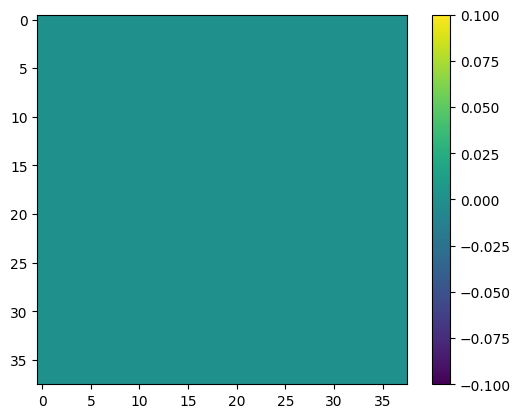

In [32]:
mafft_mat = submat[ordset , :] 
mafft_mat = mafft_mat[ : , ordset ]
mafft_mat = (mafft_mat + mafft_mat.T) / 2
plt.imshow(mafft_mat)
plt.colorbar()


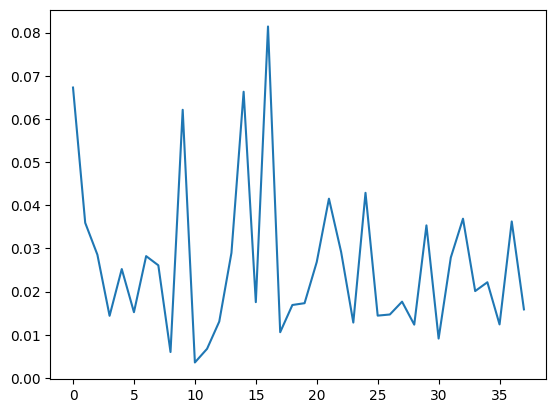

In [32]:
plt.plot( background_freq / sum(background_freq) )

In [33]:
import numpy as np

def compute_log_odds_from_counts(
	pair_counts: np.ndarray,
	char_freqs: np.ndarray,
	pseudocount: float = 1e-20,
	log_base: float = np.e
) -> np.ndarray:
	"""
	Computes a log-odds ratio matrix from a pair-count matrix and a vector of character frequencies.

	Parameters
	----------
	pair_counts : np.ndarray (n x n)
		pair_counts[i, j] = number of times character i is aligned with character j.
	char_freqs : np.ndarray (n,)
		char_freqs[i] = background frequency of character i.
	pseudocount : float
		Small value added to avoid division by zero.
	log_base : float
		Base of the logarithm (np.e for natural log, 2 for log base 2, 10 for log base 10, etc.).

	Returns
	-------
	log_odds_matrix : np.ndarray (n x n)
		log_odds_matrix[i, j] = log-odds ratio for substituting character i with character j.
	"""

	# 1. Validate input dimensions
	n = pair_counts.shape[0]
	if pair_counts.shape[1] != n:
		raise ValueError("pair_counts must be an n x n matrix.")
	if char_freqs.shape[0] != n:
		raise ValueError("char_freqs must have length n.")

	# 2. Compute total sum of pair counts (for normalization)
	total_pairs = np.sum(pair_counts)

	# 3. Compute observed frequencies with pseudocount
	#    obs_freq[i, j] = (pair_counts[i, j] + pseudocount) / (total_pairs + pseudocount_factor)
	#    You can scale pseudocount_factor as you see fit; for simplicity, we'll just add pseudocount to numerator
	obs_freq = (pair_counts + pseudocount) / (total_pairs + pseudocount * (n**2))

	# 4. Compute expected frequencies using background frequencies
	#    exp_freq[i, j] = char_freqs[i] * char_freqs[j]
	#    Note: if your background frequencies do not sum to 1, you may need to normalize them first
	char_freqs = char_freqs / np.sum(char_freqs)
	exp_freq = np.outer(char_freqs, char_freqs) + pseudocount

	# 5. Compute log-odds ratio
	#    ratio[i, j] = obs_freq[i, j] / exp_freq[i, j]
	ratio =    obs_freq / exp_freq 

	#    log_odds[i, j] = log(ratio[i, j]) / log(log_base)
	#    We add a small epsilon to avoid log(0.0) if ratio < 1e-15, etc.
	epsilon = 1e-15
	plt.imshow(ratio)
	plt.colorbar()
	plt.show()
	log_odds_matrix = np.log(ratio + epsilon) / np.log(log_base)

	return log_odds_matrix


In [41]:

def compute_raxml_compatible_matrix(pair_counts, char_freqs, pseudocount=1e-20, log_base=np.e, scaling_factor=1.0):
    # Compute the log odds matrix as you already do
    log_odds_matrix = compute_log_odds_from_counts(pair_counts, char_freqs, pseudocount, log_base)
    
    # Exponentiate the log odds to get relative rates
    preliminary_rates = np.exp(log_odds_matrix * scaling_factor)
    
    # Symmetrize the matrix to ensure reversibility
    n = preliminary_rates.shape[0]
    rate_matrix = np.zeros_like(preliminary_rates)
    for i in range(n):
        for j in range(n):
            if i != j:
                rate_matrix[i, j] = (preliminary_rates[i, j] + preliminary_rates[j, i]) / 2.0
    # Set diagonal entries so that each row sums to zero
    for i in range(n):
        rate_matrix[i, i] = -np.sum(rate_matrix[i, :]) + rate_matrix[i, i]
    
    # Scale the matrix so that the expected substitution rate is 1
    # Calculate the expected rate: sum_i πᵢ * (-Qᵢᵢ)
    char_freqs = char_freqs / np.sum(char_freqs)
    expected_rate = -np.sum(char_freqs * np.diag(rate_matrix))
    rate_matrix = rate_matrix / expected_rate

    return rate_matrix , char_freqs

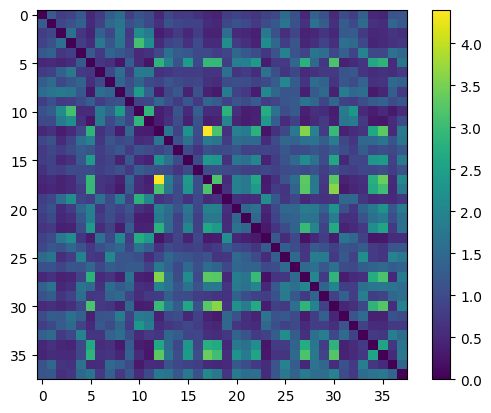

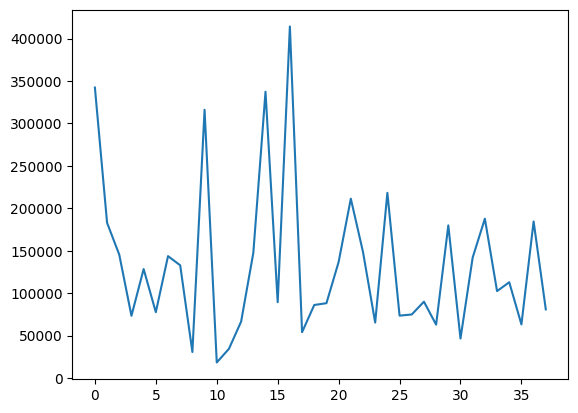

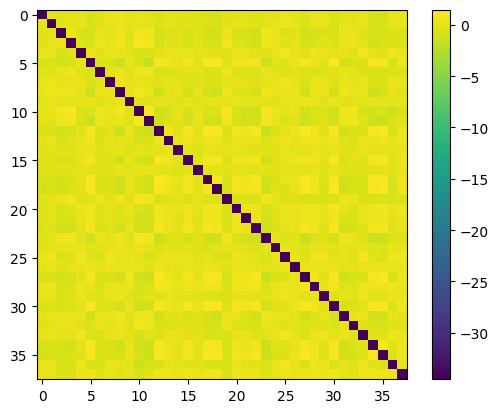

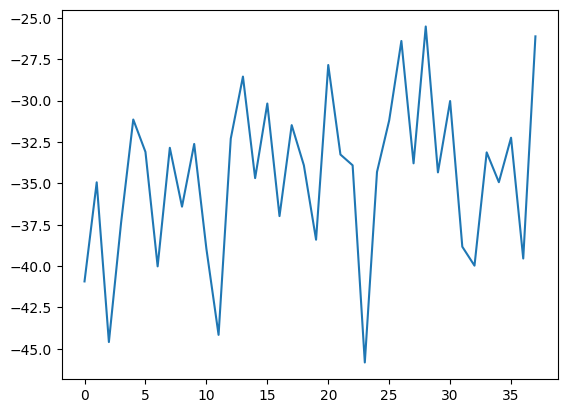

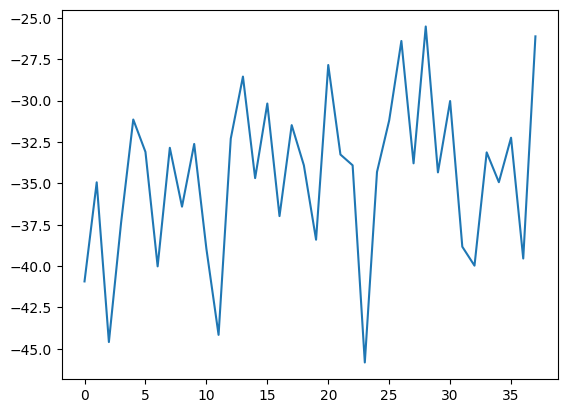

5089006.0
[[6.14160078e-19 7.72638498e-04 4.91960267e-04 ... 2.80858209e-04
  6.94088035e-04 7.07768375e-04]
 [7.72638498e-04 6.14160080e-19 5.89904572e-04 ... 3.54953524e-04
  8.91773340e-04 7.39429889e-04]
 [4.91960267e-04 5.89904572e-04 6.14160082e-19 ... 3.20544196e-04
  4.03412607e-04 3.77520248e-04]
 ...
 [2.80858209e-04 3.54953524e-04 3.20544196e-04 ... 6.14160103e-19
  3.30119565e-04 1.08619592e-03]
 [6.94088035e-04 8.91773340e-04 4.03412607e-04 ... 3.30119565e-04
  6.14160080e-19 8.80066908e-04]
 [7.07768375e-04 7.39429889e-04 3.77520248e-04 ... 1.08619592e-03
  8.80066908e-04 6.14160093e-19]]


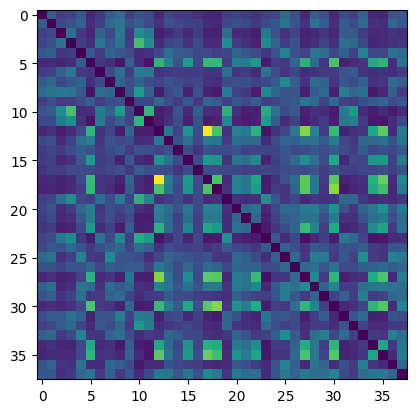

In [42]:
import copy
mafft_mat_count = copy.deepcopy(mafft_mat)
np.fill_diagonal(mafft_mat_count, 0)
#mafft_mat_count = mafft_mat_count / np.sum(mafft_mat_count)
log_odds = compute_log_odds_from_counts(mafft_mat_count, background_freq )
plt.plot( background_freq  )
plt.show()
plt.imshow(log_odds)
plt.colorbar()
plt.show()
plt.plot(np.sum(log_odds , axis= 0) )
plt.show()
plt.plot(np.sum(log_odds , axis= 1) )
plt.show()
print( np.sum( background_freq ) )

#exponential of log odds
submat = np.exp(log_odds)
submat = (submat + submat.T) / 2
submat = submat / np.sum(submat)
plt.imshow(submat)
print( submat )

In [ ]:
ords = np.array([ ord(c) for c in char_set ])
ords_original = ords.copy()
ords_original = sorted([ i if i not in rev_replace_dict_ord else rev_replace_dict_ord[i] for i in ords ])
print(ords)
print( ords_original)

[  1   2   3   4   5   6   7   8   9  11  12  14  15  16  17  18  19  20
  21  22  23  24  25  26  27  28  29  30  31  33  36  37  38  39  40 247
 248 253]
[1, 2, 3, 4, 5, 6, 7, 8, 9, 11, 12, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40]


In [ ]:
#raxml mat
inputchars = """0 1 2 3 4 5 6 7 8 9 A B C D E F G H I J K L M N O P Q R S T U V W X Y Z ! " # $ % & ' ( ) * + , / : ; < = > @ [ \ ] ^ _ { | } ~""".split()
revmap_raxml = { c:ords[i] for i,c in enumerate(inputchars[:len(char_set)]) }
map_raxml = { ords[i]:c for i,c in enumerate(inputchars[:len(char_set)]) }
raxml_alphabet = inputchars[:len(char_set)]


<>:3: SyntaxWarning: invalid escape sequence '\ '
<>:3: SyntaxWarning: invalid escape sequence '\ '
/tmp/ipykernel_3071891/1942585402.py:3: SyntaxWarning: invalid escape sequence '\ '
  inputchars = """0 1 2 3 4 5 6 7 8 9 A B C D E F G H I J K L M N O P Q R S T U V W X Y Z ! " # $ % & ' ( ) * + , / : ; < = > @ [ \ ] ^ _ { | } ~""".split()


In [ ]:
#mafft matrix file example max 248 char

"""
0x01 0x01 2   # (comment)
0x1e 0x1e 2
0x1f 0x1f 2
0x21 0x21 2   # ! × !
0x41 0x41 2   # A × A
0x42 0x42 2   # B × B
0x43 0x43 2   # C × C
"""

def formathex(hexnum):
	if len(hexnum) == 3:
		return hexnum[0:2] + '0' + hexnum[2]
	else:
		return hexnum

def output_mafft_matrix( submat , char_set ,  outpath='mafft_submat.mtx' ):
	print( submat.shape , len( char_set ) )
	with open(outpath, 'w') as f:
		for i in range(len(char_set)):
			for j in range(len(char_set)):
				if i <= j:
					stringi = char_set[i]
					stringj = char_set[j]
					
					if stringi in replace_dict.keys():
						stringi = replace_dict[stringi]
					if stringj in replace_dict.keys():
						stringj = replace_dict[stringj]
				  
					hexi = formathex(hex(ord(stringi)))
					hexj = formathex(hex( ord(stringj)))
					
					f.write( f'{hexi} {hexj} {submat[i,j]} \n ')# '+ stringi + 'x' + stringj + ' \n' )
				   
output_mafft_matrix( mafft_mat , char_set= char_set,  outpath=modelname+'_mafft_submat.mtx' )
print(modeldir + modelname+'_mafft_submat.mtx')

(38, 38) 38
small5_geo_graph_mafft_submat.mtx


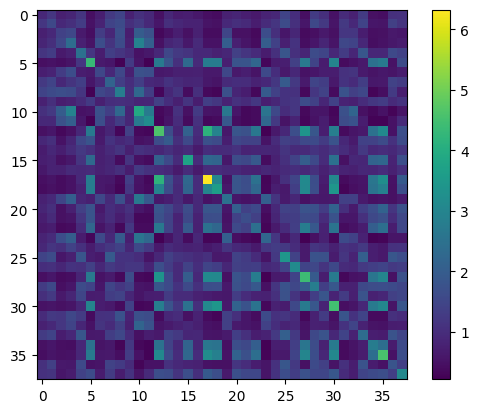

small5_geo_graphraxml_custom_matrix.txt


 0.031013

 0.019747 0.023678

 0.021731 0.027036 0.039566

 0.029875 0.033680 0.016969 0.020001

 0.012328 0.013461 0.011281 0.014114 0.030677

 0.019036 0.021328 0.033826 0.043127 0.018261 0.017320

 0.031904 0.037508 0.023485 0.029213 0.035020 0.014879 0.023889

 0.037897 0.041528 0.043664 0.041768 0.030071 0.006510 0.039262 0.035230

 0.019957 0.026686 0.018256 0.019850 0.024924 0.032607 0.019226 0.026261 0.027095

 0.027352 0.031991 0.052145 0.076332 0.013203 0.014378 0.044772 0.034942 0.059602 0.021801

 0.023874 0.024026 0.045238 0.053965 0.015677 0.005827 0.043699 0.023935 0.034204 0.022624 0.071197

 0.012529 0.015332 0.008636 0.012717 0.023071 0.070407 0.015768 0.021994 0.008492 0.035903 0.009255 0.008353

 0.023215 0.026740 0.013409 0.022068 0.039491 0.047200 0.017313 0.028789 0.023475 0.026447 0.012736 0.014754 0.042553

 0.017838 0.023557 0.018829 0.024967 0.031679 0.027636 0.019699 0.024730 0.029456 0.019482 0.027988 0.025565 0.02

In [ ]:
def raxml_matrix( matrix, background_frequencies, outfile = modelname+"_raxml_custom_matrix.txt"):
	# Create the substitution matrix file
	#lower triangular matrix
	with open(outfile, "w") as f:
		for i in range(matrix.shape[0]):
			for j in range(matrix.shape[0]):
				if j < i:
					#format to 6 decimal places
					f.write(f" {matrix[i,j]:.6f}")
			f.write("\n")
		# Add the frequencies
		for i, freq in enumerate(background_frequencies):
			f.write(f"{freq:.6f} ")
		f.write("\n")
	return outfile

submat, bg = compute_raxml_compatible_matrix( mafft_mat, background_freq, pseudocount=1e-20, log_base=np.e, scaling_factor=1.0)
outmatrix = raxml_matrix( submat , bg,  outfile = modelname+"raxml_custom_matrix.txt")
print(outmatrix)
with open(modeldir + modelname+"raxml_custom_matrix.txt", 'r') as f:
	for line in f:
		print(line)

In [ ]:
import subprocess
import Bio.PDB as PDB
def run_mafft_textaln( infasta , outaln , matrix='mafft_submat.mtx' ):
	cmd = f'mafft --text --localpair --maxiterate 1000 --textmatrix {matrix} {infasta}  > {outaln}'
	print(cmd)
	subprocess.run(cmd, shell=True)
	return outaln

def mafft_hex2fasta( intext , outfasta ):
	#% /usr/local/libexec/mafft/hex2maffttext input.hex > input.ASCII
	cmd = f'/usr/lib/mafft/lib/mafft/hex2maffttext {intext} > {outfasta}'
	print(cmd)
	subprocess.run(cmd, shell=True)
	return outfasta    


def fasta2hex( intext , outfasta ):
	#% /usr/local/libexec/mafft/maffttext2hex input.hex > input.ASCII
	cmd = f'/usr/lib/mafft/lib/mafft/maffttext2hex {intext} > {outfasta}'
	print(cmd)
	subprocess.run(cmd, shell=True)
	return outfasta    

def normal_mafft( infasta , outaln ):
	cmd = f'mafft --anysymbol {infasta} > {outaln}'
	print(cmd)
	subprocess.run(cmd, shell=True)
	return outaln

def struct2sequence(structfile):
	parser = PDB.PDBParser()
	structure = parser.get_structure('struct', structfile)
	seq = ''
	for model in structure:
		for chain in model:
			for residue in chain:
				if PDB.is_aa(residue):
					seq += residue.get_resname()
	return seq

In [ ]:
import glob
structs = glob.glob('families/fsx1/*.pdb')

In [56]:
#make normal fasta
with open( 'fsx1_example.fasta', 'w') as f:
	for s in structs:
		seq =  struct2sequence(s)
		if len(seq)>0:
			identifier = s.split('/')[-1].split('.')[0]
			f.write('>' + identifier + '\n' + seq + '\n')


/home/dmoi/miniforge3/envs/pyg/lib/python3.12/site-packages/Bio/PDB/PDBParser.py:384: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 9706
  warnings.warn(
/home/dmoi/miniforge3/envs/pyg/lib/python3.12/site-packages/Bio/PDB/PDBParser.py:384: PDBConstructionWarning: Ignoring unrecognized record ' ' at line 19
  warnings.warn(
/home/dmoi/miniforge3/envs/pyg/lib/python3.12/site-packages/Bio/PDB/PDBParser.py:384: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 3009
  warnings.warn(
/home/dmoi/miniforge3/envs/pyg/lib/python3.12/site-packages/Bio/PDB/PDBParser.py:384: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 3774
  warnings.warn(
/home/dmoi/miniforge3/envs/pyg/lib/python3.12/site-packages/Bio/PDB/PDBParser.py:384: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 6559
  warnings.warn(
/home/dmoi/miniforge3/envs/pyg/lib/python3.12/site-packages/Bio/PDB/PDBParser.py:384: PDBConstructionWarning: Ignoring unrecogniz

In [70]:
#raxml cmd using subprocess
import subprocess
def run_raxml_ng(fasta_file, matrix_file, nsymbols, output_prefix , iterations = 20 ):
	raxml_cmd ='./raxml-ng  --model MULTI'+str(nsymbols)+'_GTR{'+matrix_file+'}+I+G --redo  --all --bs-trees '+str(iterations)+' --seed 12345 --threads 8 --msa '+fasta_file+' --prefix '+output_prefix 
	print(raxml_cmd)
	subprocess.run(raxml_cmd, shell=True)
	return None


def run_raxml_ng_normal(fasta_file, output_prefix, iterations = 20):
	raxml_cmd ='./raxml-ng  --model LG+I+G  --redo --all --bs-trees ' +str(iterations)+' --seed 12345 --threads 8 --msa '+fasta_file+' --prefix '+output_prefix 
	print(raxml_cmd)
	subprocess.run(raxml_cmd, shell=True)
	return None


#ancestral reconstruction
#raxml-ng --ancestral --msa ali.fa --tree best.tre --model HKY --prefix ASR

def run_raxml_ng_ancestral_struct(fasta_file, tree_file, matrix_file, nsymbols, output_prefix):
	model = 'MULTI'+str(nsymbols)+'_GTR{'+matrix_file+'}+I+G'
	raxml_cmd ='./raxml-ng  --redo --ancestral --msa '+fasta_file+' --tree '+tree_file+' --model '+model+' --prefix '+output_prefix 
	print(raxml_cmd)
	subprocess.run(raxml_cmd, shell=True)
	return None

def run_raxml_ng_ancestral_normal(fasta_file, tree_file, model = 'LG+I+G', output_prefix='ASR'):
	raxml_cmd ='./raxml-ng  --ancestral --msa '+fasta_file+' --tree '+tree_file+' --model '+model+' --prefix '+output_prefix 
	print(raxml_cmd)
	subprocess.run(raxml_cmd, shell=True)
	return None

def madroot( treefile  ):
	mad_cmd = f'./madroot/mad {treefile} '
	print(mad_cmd)
	subprocess.run(mad_cmd, shell=True)
	return treefile+'.rooted'

In [71]:

run_raxml_ng('fsx1_encoded.aln.remap.fasta'  ,'raxml_custom_matrix.txt' , len(char_set) , 'fsx1_example' )


./raxml-ng  --model MULTI38_GTR{raxml_custom_matrix.txt}+I+G --redo  --all --bs-trees 20 --seed 12345 --threads 8 --msa fsx1_encoded.aln.remap.fasta --prefix fsx1_example

RAxML-NG v. 1.2.2-master released on 30.04.2024 by The Exelixis Lab.
Developed by: Alexey M. Kozlov and Alexandros Stamatakis.
Contributors: Diego Darriba, Tomas Flouri, Benoit Morel, Sarah Lutteropp, Ben Bettisworth, Julia Haag, Anastasis Togkousidis.
Latest version: https://github.com/amkozlov/raxml-ng
Questions/problems/suggestions? Please visit: https://groups.google.com/forum/#!forum/raxml

System: Intel(R) Xeon(R) Silver 4110 CPU @ 2.10GHz, 16 cores, 251 GB RAM

RAxML-NG was called at 12-Feb-2025 00:22:22 as follows:

./raxml-ng --model MULTI38_GTR{raxml_custom_matrix.txt}+I+G --redo --all --bs-trees 20 --seed 12345 --threads 8 --msa fsx1_encoded.aln.remap.fasta --prefix fsx1_example

Analysis options:
  run mode: ML tree search + bootstrapping (Felsenstein Bootstrap)
  start tree(s): random (10) + parsimony (1

In [72]:
run_raxml_ng_ancestral_struct(fasta_file='fsx1_encoded.aln.remap.fasta', tree_file= 'fsx1_example.raxml.bestTree', matrix_file='raxml_custom_matrix.txt', nsymbols=len(char_set), output_prefix='ancestral_1st')

./raxml-ng  --redo --ancestral --msa fsx1_encoded.aln.remap.fasta --tree fsx1_example.raxml.bestTree --model MULTI38_GTR{raxml_custom_matrix.txt}+I+G --prefix ancestral_1st

RAxML-NG v. 1.2.2-master released on 30.04.2024 by The Exelixis Lab.
Developed by: Alexey M. Kozlov and Alexandros Stamatakis.
Contributors: Diego Darriba, Tomas Flouri, Benoit Morel, Sarah Lutteropp, Ben Bettisworth, Julia Haag, Anastasis Togkousidis.
Latest version: https://github.com/amkozlov/raxml-ng
Questions/problems/suggestions? Please visit: https://groups.google.com/forum/#!forum/raxml

System: Intel(R) Xeon(R) Silver 4110 CPU @ 2.10GHz, 16 cores, 251 GB RAM

RAxML-NG was called at 12-Feb-2025 00:32:27 as follows:

./raxml-ng --redo --ancestral --msa fsx1_encoded.aln.remap.fasta --tree fsx1_example.raxml.bestTree --model MULTI38_GTR{raxml_custom_matrix.txt}+I+G --prefix ancestral_1st

Analysis options:
  run mode: Ancestral state reconstruction
  start tree(s): user
  random seed: 1739316747
  tip-inner: O

In [75]:
#turn the ancestral state file into a fasta

def ancestral2fasta( ancestral_file , outfasta ):
	with open( outfasta , 'w') as g:        
		with open( ancestral_file , 'r') as f:
			for l in f:
				words = l.split('	')
				if len(words) == 2:
					identifier, seq = words
					g.write('>' + identifier + '\n' + seq + '\n')
	return outfasta

outfasta = ancestral2fasta('ancestral_1st.raxml.ancestralStates' , 'ASR.ancestral.fasta' )
with open(outfasta, 'r') as f:
	for l in f:
		print(l)    


>Node1

WWWZWWZWWWPZRRNYMY2IWILWOPJOZ0SIWZLN3SPRQY27N32KWPCK7722K3AZWYWWWPWWTL2CIWJWWQWWCW3WCWWWZIWLPKJKVKDOSZWGLRWNCWRCJK5XZNKWWGWWWW3W2HXWPNNZVKKN52QHL"ZZWWZMWWW1PLWWZMXWWWWZLW2WWZPLVWZZLP12WGW2XWWNKHRXRHZKRMROWI1WWWWWWWWGWGML"IWL11ZHCOWWWWWWWLWZIWWRWWWWWNWWWWR77ELZ3R1"OGWJLWLIWWLMLJOWPWS3WWKCX2F1PIGWWWXZL"I82X3"GJJWWWLWNSCOZPP"3ZXZZW7S4GRWXWNPK"2KJKZ2MWWCCWQFMMRVLPL72RWIWWWRXSR!SJ8Y3LRWWWWWW2WWWGP3W5W7I2WWLIRJLWWW2KGR07R57IV5SSW4WSRLLJJ2!WWWWJZWWWZ2Y9WJ2YN2MNW22WWRYW2ICQZMWE7KCJKWWWKLY2W3JLKKI5MWWWWWWWWWWWWINJLXKL2GWWCWWKWWJKLC2IKPRPLWWWWW2WOWWWZ3KNCVNWWC23PKOFZKW28KI2JK5G3KP2W2WWW2LMVWLK2KICKWWWWWOWWWWIKZWKPGZKEY5LKE2RIKOKJOLZOWWGPWWKCZWKIKIGPZZWZZZ7ZOKWIKWWWWWWWZO1K2ZP22XKPWWZ0K2P7ZKPKPZ10WWWWYWWWZO2L2WWNKKWEZ2L23NNWWWWW2NMWWWW45TOM2ZPWWWLP3K1ZMWJNJ2OLNWWWWPWW2PE0WL1KWLU22WWWGWR3K5IKLPLPWOR21GWWZOWWWN1XX



>Node2

M1K3FP3S14P32KNYMY2N"IXVZPJ2Z01IZZLN3SPRQYNPPJ2JOPCK772ZK3PZO235OPX2TLCCIKJK1QS0CLC1C10EL3W2PKZKVKDOS21GLJWWCRRWPKKCJN1J1GRR0T302LVCRNNZVKKR52QHL"ZZS"NZ8881ZLWWGG1WWWWZ